# Quickstart
ATHENA is an open-source computational framework written in Python that facilitates the visualization, processing and analysis of (spatial) heterogeneity from spatial omics data. ATHENA supports any spatially resolved dataset that contains spatial transcriptomic or proteomic measurements, including Imaging Mass Cytometry (IMC), Multiplexed Ion Beam Imaging (MIBI), multiplexed Immunohistochemisty (mIHC) or Immunofluorescence (mIF), seqFISH, MERFISH, Visium.

### **_Important_**
You are strongly advised to read the sections:
- Note on Phenotype Encodings
- Note on Segmentation Masks

at the end of this document.

### Requirements
To use all the capabilities of ATHENA one needs the (cell-) segmenation masks for a sample and the omics-profiles of the observations in the sample (as extracted from the high-dimensional images produced by different omics-technologies).

However, it is also possible to use ATHENA (with some limitations) without segmentation masks and the omics-profiles and just the single-observation coordinates and a classification of those observations (phenotypes).

### Further Resources
- A more comprehensive tutorial on IMC data can be found [here](https://ai4scr.github.io/ATHENA/source/tutorial.html)
- A tutorial on how to load your data can be found [here](https://ai4scr.github.io/ATHENA/source/introduction-spatialOmics.html)

In [1]:
# Import Local package
import athena as ath
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

pd.set_option("display.max_columns", 5)
print(ath.__version__)

0.1.3


### Load Example Data
To use ATHENA you need to load the data in a SpatialOmics instance (see below, [here](https://ai4scr.github.io/ATHENA/source/overview.html#spatialomics-data-structure) for a general description and [here](https://ai4scr.github.io/ATHENA/source/introduction-spatialOmics.html) for a more detailed tutorial). The structure of the SpatialOmics instance is very similar to the AnnData.

For this tutorial we provide a small example of a populated SpatialOmics instance. Meta data for each stored sample can be found in `so.spl`. You can access the data by indexing the different attributes by the sample name (`so.X[spl]`, `so.obs[spl`, ...).

In [2]:
so = ath.dataset.imc_quickstart()
so

INFO:numexpr.utils:NumExpr defaulting to 8 threads.



SpatialOmics object with 5505 observations across 2 samples.
    X: 2 samples,
    spl: 2 samples,
        columns: ['pid', 'cell_count', 'immune_cell_count']
    obs: 2 samples,
        columns: ['cell_type', 'core', 'meta_id', 'cell_type_id', 'tumor_immune', 'x', 'y', 'tumor_immune_id', 'meta_label', 'id', 'CellId', 'phenograph_cluster']
    var: 2 samples,
        columns: ['full_target_name', 'feature_type', 'metal_tag', 'fullstack_index', 'target', 'channel']
    G: 0 samples,
        keys: []
    masks: 2 samples
        keys: [{'cellmasks'}]
    images: 0 samples

In [3]:
samples = so.spl.index
samples

Index(['SP43_75_X2Y5', 'SP41_239_X11Y3_165'], dtype='object', name='core')

### How to Create a SpatialOmics Instance with Dummy Data

In [4]:
# create dummy data

n_obs = 100  # number of observations (cells)
n_var = 5  # number of features
samples = ['sample_'+ str(i) for i in range(5)]  # sample names
mask_dim = [100,100]  # dimension of segmentation masks

# sample-level meta data
spl = pd.DataFrame({'samples': samples, 'age': np.random.choice(range(50,80), len(samples))}).set_index('samples')

# observation-level meta data
obs = pd.DataFrame({
    'phenotype': range(n_obs),
    'x': np.random.randint(0, mask_dim[0], n_obs),
    'y': np.random.randint(0, mask_dim[1], n_obs)})

# observation-level omics profiles
X = pd.DataFrame(np.random.rand(n_obs, n_var), columns=['var_' + str(i) for i in range(n_var)])
# high-dimensional images of samples, first dimension is the number of features, i.e. multiplexing
img = np.random.rand(n_var, *mask_dim)
# segmentation masks of images
mask = np.zeros(mask_dim, dtype=int)
# feature annotation
var = pd.DataFrame({'target': ['var_' + str(i) for i in range(n_var)]})

In [5]:
# create SpatialOmics instance

from spatialOmics import SpatialOmics
dummy = SpatialOmics()

dummy.spl = spl
for spl in samples:
    dummy.obs[spl] = obs
    dummy.X[spl] = X
    dummy.var[spl] = var
    dummy.images[spl] = img
    dummy.masks[spl] = {'cellmasks': mask}
    
dummy


SpatialOmics object with 500 observations across 5 samples.
    X: 5 samples,
    spl: 5 samples,
        columns: ['age']
    obs: 5 samples,
        columns: ['x', 'y', 'phenotype']
    var: 5 samples,
        columns: ['target']
    G: 0 samples,
        keys: []
    masks: 5 samples
        keys: [{'cellmasks'}]
    images: 5 samples

### Minimal Working Example 
Depending on your use case you do not need to populate all attributes of the SpatialOmics instance.

For a minimal working example you only need to populate the `.obs` attribute with the observation coordinates and a label.

In [6]:
dummy_min = SpatialOmics()
dummy_min.obs[spl] = obs
dummy_min


SpatialOmics object with 100 observations across 1 samples.
    X: 0 samples,
    spl: 0 samples,
        columns: []
    obs: 0 samples,
        columns: ['x', 'y', 'phenotype']
    var: 0 samples,
        columns: []
    G: 0 samples,
        keys: []
    masks: 0 samples
        keys: [set()]
    images: 0 samples

### Sample-level Meta Data
Sample-level meta data is stored in the `so.spl` attribute but not required to use ATHENA.

In [7]:
so.spl.head(3) 

,pid,cell_count,immune_cell_count
core,,,
SP43_75_X2Y5,75,2771,940
SP41_239_X11Y3_165,239,2734,412


### Observation-level Meta Data
Observation-level meta data is stored in the `so.obs` attribute and required to use ATHENA. At least the coordinates of the 
observations along with some classification of those (phenotypes) are required. 

In [8]:
spl = so.spl.index[0]
so.obs[spl].head()

,core,meta_id,...,y,x
cell_id,,,,,
1,SP43_75_X2Y5,9,...,1.142857,33.107143
2,SP43_75_X2Y5,3,...,4.868613,43.693431
3,SP43_75_X2Y5,10,...,5.467391,61.326087
4,SP43_75_X2Y5,8,...,2.353659,79.987805
5,SP43_75_X2Y5,3,...,2.026316,128.302632


### Observation-level Omics Profiles
The omics-profiles of the obserations are stores in the `so.X` attribute. These are the gene / protein expression values of the observations (most likely single cells or patches). You only need to provide this information if you want to use `metrics.quadratic_entropy()`.

In [9]:
so.X[spl].head()

target,H3,H3K28me3,...,PARP,DNA2
cell_id,,,,,
1,8.252318,0.442500,...,0.674024,9.002035
2,12.754854,1.436547,...,0.852686,19.567230
3,1.946717,0.470739,...,0.858645,2.316239
4,7.552009,0.562183,...,0.939330,8.991525
5,15.079700,0.492224,...,0.828238,12.647001


## Compute Graphs
ATHENA can construct `knn`, `radius` and `contact` graphs. By default, ATHENA tries to build the graphs from segmentation masks. Without segmentation masks, one can only use the `kNN` and `radius` graph functionality of ATHENA. For the `contact` graph the segmentation masks are required. See the [main tutorial](https://ai4scr.github.io/ATHENA/source/tutorial.html) to see how the graph construction can be customized.

The function to responsible for constructing them is `build_graph`, which takes in the following parameters:

In [10]:
from inspect import signature
signature(ath.graph.build_graph)

<Signature (so: spatialOmics.spatialOmics.SpatialOmics, spl: str, builder_type: str = None, key_added: str = None, config: dict = None, inplace: bool = True)>

If no `config` variable is passed, the `builder_type` variable must specified. Then the the default `config` for the graph type selected is used. On the other hand if one specifies the `config` variable, `builder_type` must be `None`. Both `config` can `builder_type` cannot be `None`

In [11]:
try:
    ath.graph.build_graph(so, spl)
except ValueError as e:
    print(e)

Either config or builder_type must be specified. Both are None


To change the default functionality one can adjust the `config` dictionary that is passed to the `build_graph` function. The default config for each of the graph types are as follows:

In [12]:
from athena.utils.default_configs import get_default_config
import json

for builder_type in ["knn", "radius", "contact"]:
    config = get_default_config(
        builder_type = builder_type,
        build_concept_graph = False,
        build_and_attribute = False,
        attrs_type = None
    )
    print(f"{builder_type} default config:")
    print(json.dumps(config, indent=3))
    print()

knn default config:
{
   "builder_type": "knn",
   "builder_params": {
      "n_neighbors": 6,
      "mode": "connectivity",
      "metric": "minkowski",
      "p": 2,
      "metric_params": null,
      "include_self": true,
      "n_jobs": -1
   },
   "coordinate_keys": [
      "x",
      "y"
   ],
   "mask_key": null,
   "build_and_attribute": false,
   "build_concept_graph": false
}

radius default config:
{
   "builder_type": "radius",
   "builder_params": {
      "radius": 36,
      "mode": "connectivity",
      "metric": "minkowski",
      "p": 2,
      "metric_params": null,
      "include_self": true,
      "n_jobs": -1
   },
   "coordinate_keys": [
      "x",
      "y"
   ],
   "mask_key": null,
   "build_and_attribute": false,
   "build_concept_graph": false
}

contact default config:
{
   "builder_type": "contact",
   "builder_params": {
      "dilation_kernel": "disk",
      "radius": 4,
      "include_self": true
   },
   "coordinate_keys": null,
   "mask_key": "cellmasks"

### From Segmentation Masks
Provide the `spatialOmics` instance and sample name for which the graph should be computed. Furthermore, `builder_type` defines the type of graph that is constructed and `mask_key` the segmentation masks that should be used (stored at `so.masks[spl][MASK_KEY]`). In this case we want to use `'cellmasks'` `mask_key`.

In [13]:
config = get_default_config(builder_type = "knn")
config["mask_key"] = 'cellmasks' # Set to 'cellmasks' since the default is None
ath.graph.build_graph(so, spl, config=config)
so.G[spl].keys()  # graphs are stored at so.G[spl]

dict_keys(['knn'])

One can build multiple graph-representations for each sample by simply calling `build_graph` again with another `builder_type`

In [14]:
ath.graph.build_graph(so, spl, builder_type='radius')
so.G[spl].keys()  # graphs are stored at so.G[spl]

dict_keys(['knn', 'radius'])

### From Coordinates

One can build the `knn` and `radius` graphs from coordinates only by setting `config['mask_key']=None` and providing the column names of the coordinates in the config at `config['coordinate_keys']` (they must be column names in `so.obs[spl]`). 

- For `knn` and `radius` config `['mask_key']=None` and `config['coordinate_keys'] = ['x', 'y']` by default. 
- For `contact` the default is `config['mask_key']="cellmasks"` and `config['coordinate_keys'] = None`.

In [15]:
ath.graph.build_graph(so, spl, config=get_default_config(builder_type = "knn"))
ath.graph.build_graph(so, spl, config=get_default_config(builder_type = "radius"))
so.G[spl].keys()  # graphs are stored at so.G[spl]

dict_keys(['knn', 'radius'])

Note how the default keys for the generated graphs are the name of the building method. In order to avoid overwriting a previous graph built with the same method one can specify the key that shall be used to store the generated graph. 

In [16]:
ath.graph.build_graph(
    so, 
    spl, 
    config=get_default_config(builder_type = "radius"),
    key_added="radius_2"
)
so.G[spl].keys()

dict_keys(['knn', 'radius', 'radius_2'])

## Visualise the Data
For some of the plotting functionalities ATHENA requires the x,y coordinates of each observation. They can be extracted from segmentation masks with

In [17]:
ath.pp.extract_centroids(so, spl, mask_key='cellmasks')

The data can then be visualised with 

/Users/santiago/eth/22-2/thesis/ATHENA/athena/plotting/visualization.py:217: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


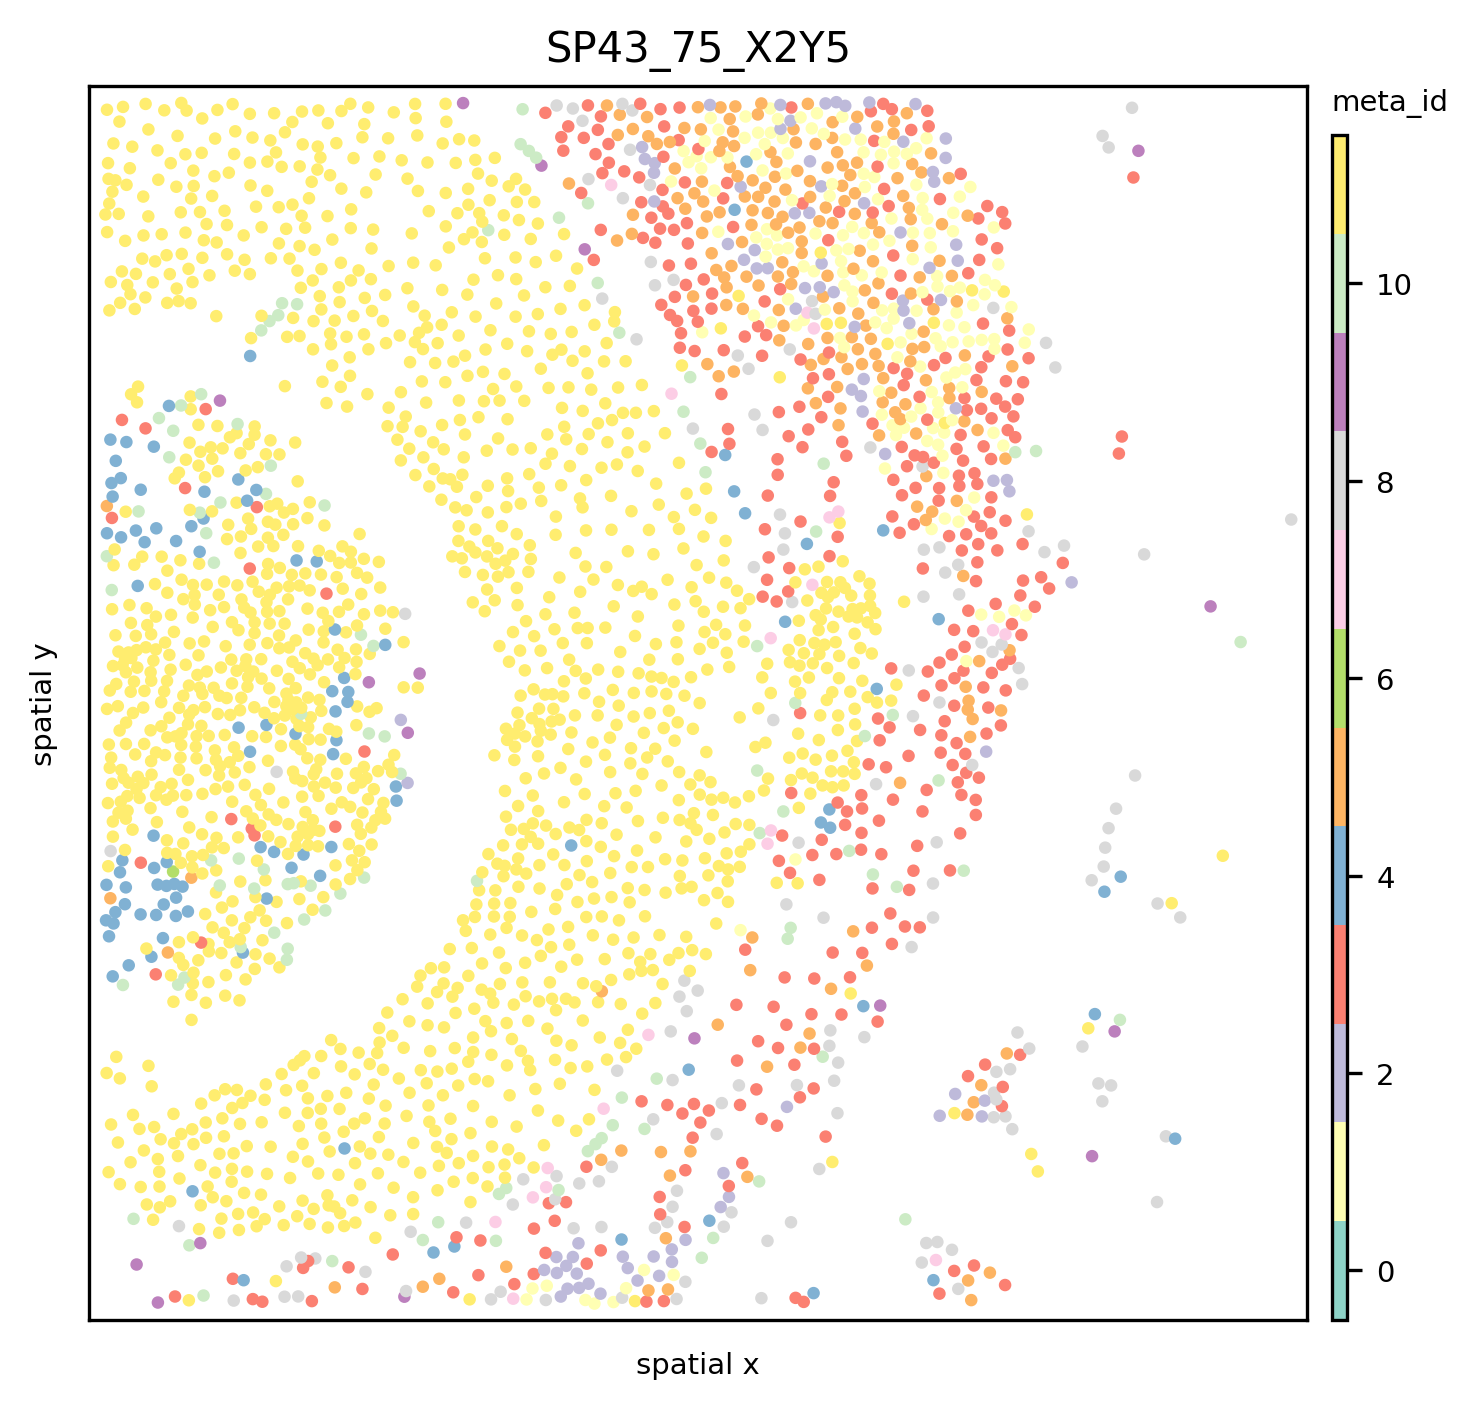

In [18]:
ath.pl.spatial(so, spl, attr='meta_id')

or if one wants to use custom coordinates, one can provide coordinate keys that are stored in the `so.obs[spl]` dataframe ATHENA should use 

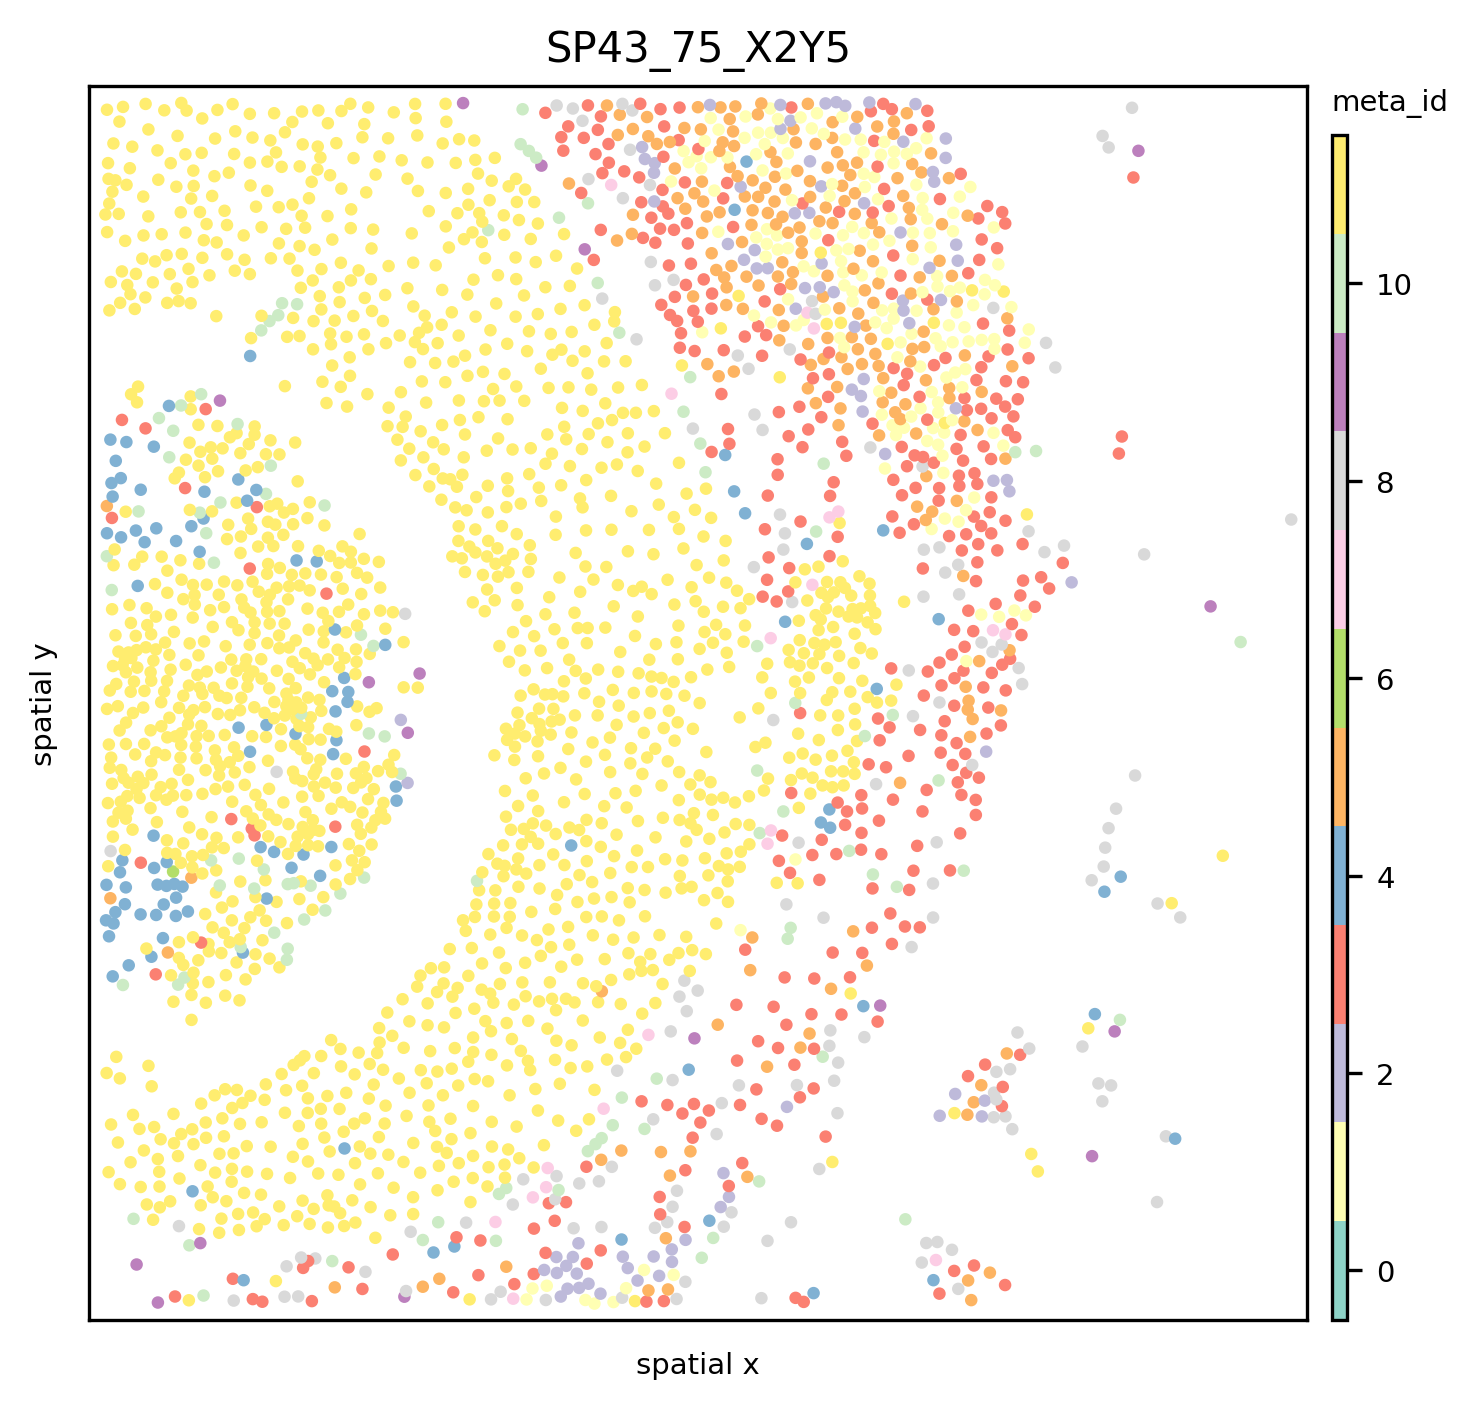

In [19]:
ath.pl.spatial(so, spl, attr='meta_id', coordinate_keys=['x', 'y'])

See the [main tutorial](https://ai4scr.github.io/ATHENA/source/tutorial.html) and the [docs](https://ai4scr.github.io/ATHENA/api/athena.plotting.visualization.html?highlight=spatial#athena.plotting.visualization.spatial)  to see how the plotting can be customized.

## Compute Metrics
Once the graphs are built we can use the quantifications methods from the `ath.metrics` and the `ath.neigh` module. Again, provide the `spatialOmics` instance and the sample name for which the metric should be computed. Furthermore, since ATHENA quantifies the phenotypic heterogeneity in the data, provide the column name that indicates the different phenotypes of each observation with `attr` and specify the graph topologie to use with `graph_key`.

Most of the metrics can be computed either on a sample-level (i.e. 1 value per sample) or on a observation-level (i.e. 1 value per observation). This behaviour can be controlled by setting `local={True,False}`.

In [20]:
# compute shannon entropy for each observation, once for the radius graph and once for the knn graph
ath.metrics.shannon(so, spl, attr='meta_id',graph_key='radius')
ath.metrics.shannon(so, spl, attr='meta_id',graph_key='knn')

# compute the shannon entropy for the whole sample
ath.metrics.shannon(so, spl, attr='meta_id', local=False)

The results for `local=True` (default) are stores in `so.obs` as `{method}_{attr}_{graph_key}`.

In [21]:
so.obs[spl].head()

,core,meta_id,...,shannon_meta_id_radius,shannon_meta_id_knn
cell_id,,,,,
1,SP43_75_X2Y5,9,...,1.921928,1.918296
2,SP43_75_X2Y5,3,...,1.918296,1.918296
3,SP43_75_X2Y5,10,...,2.446439,2.521641
4,SP43_75_X2Y5,8,...,2.419382,2.128085
5,SP43_75_X2Y5,3,...,1.870254,1.459148


The results for `local=False` are stored in `so.spl`

In [22]:
so.spl.loc[spl].head()

pid                    75.000000
cell_count           2771.000000
immune_cell_count     940.000000
shannon_meta_id         3.311329
Name: SP43_75_X2Y5, dtype: float64

## Note On Phenotype Encodings
We advise the users to use _numeric_ phenotype encodings when computing metrics. If one has label names stored in a `pd.DataFrame` as `label_names` one can easily create numeric labels by

In [23]:
df = pd.DataFrame({'label_names': ['A', 'B', 'B', 'C']})
df['labels_names_id'] = df.groupby('label_names').ngroup()

Furthermore, some functions require a strict `categorical` encoding. Thus the columns `dtype` should be set to `categorical` and include all categories across the samples. This can be achived by running the following snippet for all `categorical` columns in `so.obs[spl]`

In [24]:
# collect all occurences in the dataset
i = set()
for spl in so.spl.index:
    i.update(so.obs[spl]['meta_id'].values)

# define categorical dtype
dtype = pd.CategoricalDtype(i)
for spl in so.spl.index:
    so.obs[spl].loc[:,'meta_id'] = so.obs[spl]['meta_id'].astype(dtype)

## Note On Segmentation Masks
Segmentation masks should be stored as `np.ndarray` and have `int` encodings with 0 being background. The labels do not need to be sequential but aligned with the index in `so.obs[spl]`, i.e. the label of the segmentation mask should be the same as in the index of the `so.obs` dataframe for a given observation. One can test that the labels overlap

In [25]:
ids = np.unique(so.masks[spl]['cellmasks'])
ids = ids[ids!=0]  # remove background label
s_mask = set(ids)
s_obs = set(so.obs[spl].index.values)
assert len(s_obs - s_mask) == 0
assert len(s_mask - s_obs) == 0